## Import Package

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [3]:
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [8, 6]

## Load & Check Data

In [4]:
data = pd.DataFrame({
    
    'gas':[1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.861 , 1.8839],
    'beetles':[59, 60, 62, 56, 63, 59, 62, 60],
    'deaths':[ 6, 13, 18, 28, 52, 53, 61, 60]
})

In [5]:
data

,gas,beetles,deaths
0,1.6907,59,6
1,1.7242,60,13
2,1.7552,62,18
3,1.7842,56,28
4,1.8113,63,52
5,1.8369,59,53
6,1.8610,62,61
7,1.8839,60,60


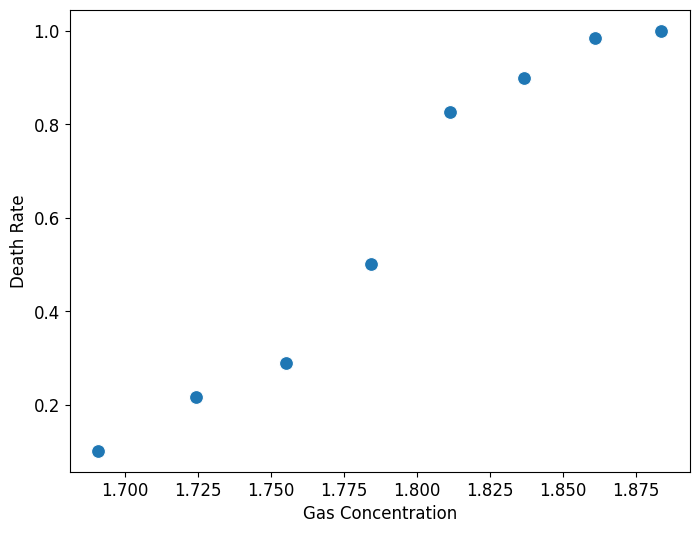

In [6]:
sns.scatterplot(x=data['gas'], y=data['deaths']/data['beetles'], s=100)

plt.xlabel('Gas Concentration')
plt.ylabel('Death Rate');

## Preprocess & Scale Data

In [7]:
gas = data['gas'].values
deaths = data['deaths'].values
beetles = data['beetles'].values

In [8]:
gas_mu = np.mean(gas)
gas_sd = np.std(gas)

gas_scaled = (gas - gas_mu) / gas_sd

## Define Model & Inference

In [9]:
def model(gas_scaled=None, deaths=None, beetles=None, num_data=0):
    
    a = numpyro.sample('a', dist.Normal(0, 10))
    b = numpyro.sample('b', dist.Normal(0, 10))
    
    mu = a * gas_scaled + b
    
    theta = jax.nn.sigmoid(mu)
    
    with numpyro.plate('plate_obs', num_data):
        
        numpyro.sample('obs', dist.Binomial(total_count=beetles, probs=theta), obs=deaths)
    

In [10]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), gas_scaled=gas_scaled, deaths=deaths, beetles=beetles, num_data=len(gas_scaled))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

In [11]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

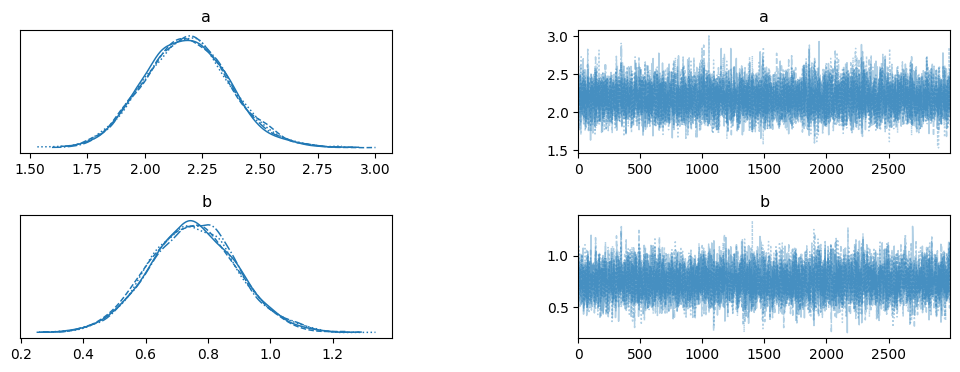

In [13]:
az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.184,0.185,1.842,2.537,0.002,0.002,8685.0,7338.0,1.0
b,0.753,0.141,0.489,1.020,0.002,0.001,7251.0,6983.0,1.0


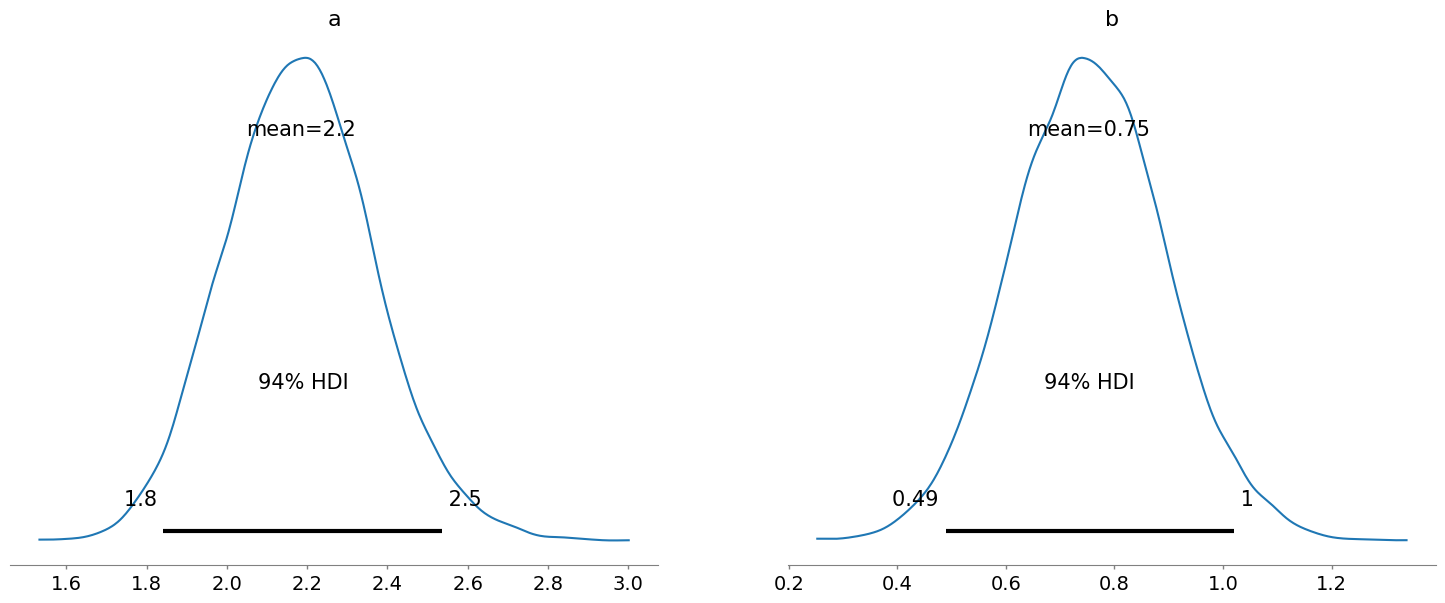

In [15]:
az.plot_posterior(idata);

## Check MCMC-samples

In [16]:
def plot_curves(trace):

    samples_to_plot = 50

    x_scaled_new = np.linspace(-2, 2, 50)
        
    for k in range(1, samples_to_plot):
        
        a_sample = trace['a'][-k]
        b_sample = trace['b'][-k]
    
        mu = a_sample * x_scaled_new + b_sample
        
        p = 1 / (1 + np.exp(-mu))
        
        plt.plot(x_scaled_new, p, c='g', alpha=0.2)
    

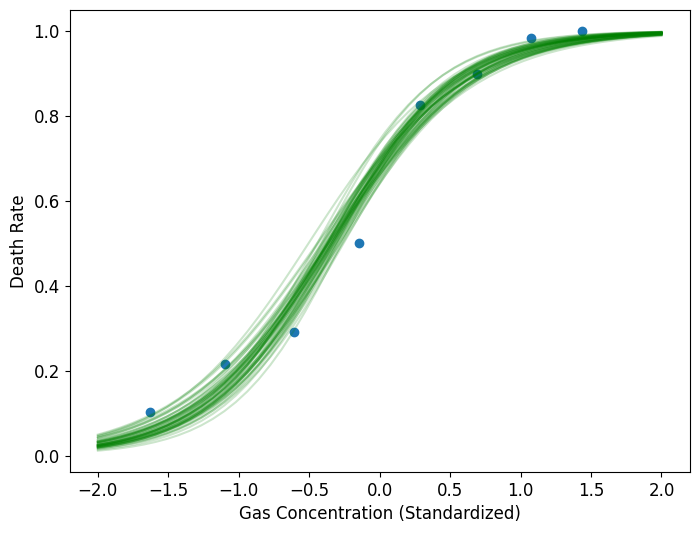

In [17]:
plt.scatter(gas_scaled, deaths / beetles)
plot_curves(mcmc_samples)

plt.xlabel('Gas Concentration (Standardized)')
plt.ylabel('Death Rate');

## Posterior Predictive Check

In [18]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), gas_scaled=gas_scaled, beetles=beetles, num_data=len(gas_scaled))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

In [19]:
ppc_samples['obs'].shape

(12000, 8)

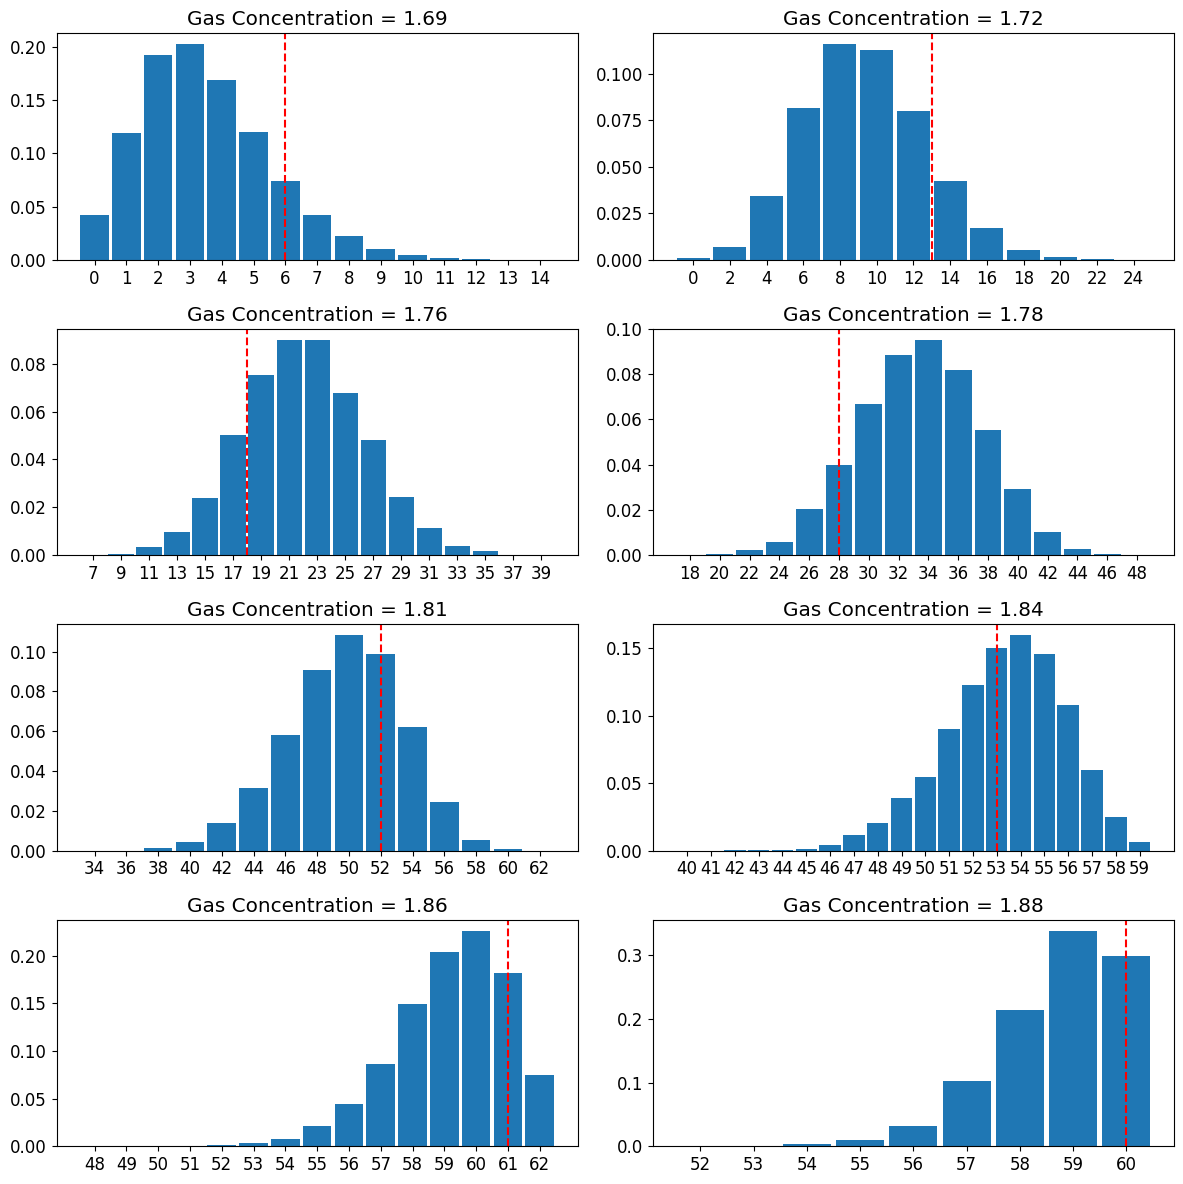

In [20]:
fig = plt.figure(figsize=(12, 12))

for k in range(8):
    
    ax = fig.add_subplot(4, 2, k+1)
    
    az.plot_dist(ppc_samples['obs'][:, k])
    ax.axvline(deaths[k], color='r', linestyle='dashed')
    ax.set_title('Gas Concentration = {:.2f}'.format(gas[k]))

plt.tight_layout()